In [37]:
import pandas as pd
import numpy as np

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [38]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [39]:
labels = train_df['label'].values
cat_features = ['pickup_date', 'pickup_year', 'pickup_hour',
       'pickup_minute', 'drop_date', 'drop_year', 'drop_hour', 'drop_minute','pick_cluster','duration_bin', 'meter_waiting_bin',
       'duration_meter_waiting_cat']
train_df = train_df.drop(['label'], axis=1)

In [42]:
params = {
    'objective':'binary',
    'num_iterations':1000, 
    'early_stopping_rounds':50,
    'seed':0
}

In [43]:
threshold = 0.5
predictions = np.zeros(submission_df.shape[0])

In [44]:
skf = StratifiedKFold(n_splits=3)
validation_scores = []
models = []

for train_index, test_index in skf.split(train_df, labels):
    X_train, X_test = train_df.iloc[train_index,:], train_df.iloc[test_index,:]
    y_train, y_test = labels[train_index], labels[test_index]
    train = lgb.Dataset(X_train,label=y_train, categorical_feature=cat_features)
    test = lgb.Dataset(X_test,label=y_test, categorical_feature=cat_features)
    model = lgb.train(params,train_set=train,valid_sets=test)
    models.append(model)
    pred = model.predict(X_test.values)    
    pred = np.where(pred > threshold, 1, 0)
    validation_score = f1_score(y_test, pred, average='macro')
    print('Validation f1',validation_score)
    validation_scores.append(validation_score)
    
    pred = model.predict(test_df.values)
    predictions += pred

/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[1]	valid_0's binary_logloss: 0.267521
Training until validation scores don't improve for 50 rounds
[2]	valid_0's binary_logloss: 0.253385
[3]	valid_0's binary_logloss: 0.243077
[4]	valid_0's binary_logloss: 0.236907
[5]	valid_0's binary_logloss: 0.232774
[6]	valid_0's binary_logloss: 0.227661
[7]	valid_0's binary_logloss: 0.22338
[8]	valid_0's binary_logloss: 0.221983
[9]	valid_0's binary_logloss: 0.217186
[10]	valid_0's binary_logloss: 0.217681
[11]	valid_0's binary_logloss: 0.214104
[12]	valid_0's binary_logloss: 0.211583
[13]	valid_0's binary_logloss: 0.213251
[14]	valid_0's binary_logloss: 0.21415
[15]	valid_0's binary_logloss: 0.215874
[16]	valid_0's binary_logloss: 0.215371
[17]	valid_0's binary_logloss: 0.216997
[18]	valid_0's binary_logloss: 0.216174
[19]	valid_0's binary_logloss: 0.216654
[20]	valid_0's binary_logloss: 0.217209
[21]	valid_0's binary_logloss: 0.215473
[22]	valid_0's binary_logloss: 0.215077
[23]	valid_0's binary_logloss: 0.212873
[24]	valid_0's binary_logloss:

In [45]:
np.mean(validation_scores), np.std(validation_scores)

(0.7255230548875375, 0.010719075984140472)

In [46]:
validation_scores

[0.7356276624836032, 0.7302569946961097, 0.7106845074828999]

In [47]:
best_model = models[2]

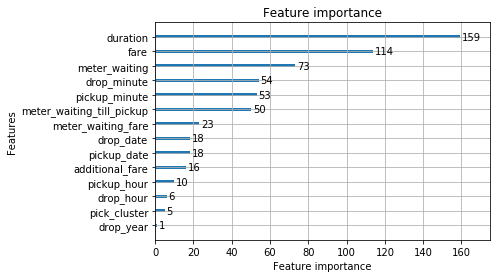

In [48]:
lgb.plot_importance(best_model)

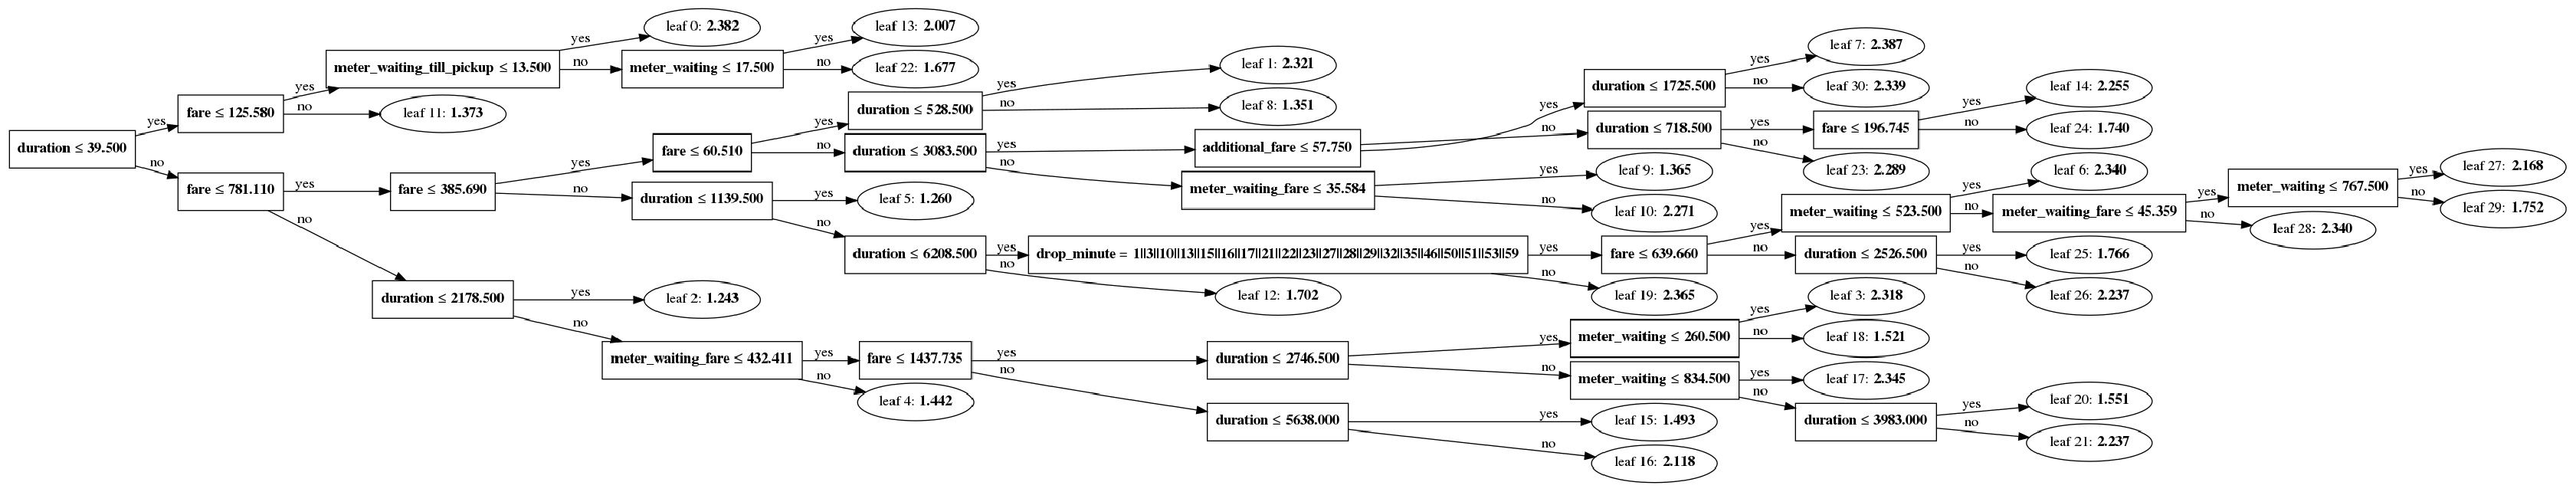

In [49]:
lgb.plot_tree(best_model,figsize=(60,60))

In [32]:
submission_df['prediction'] = np.where(predictions / 3 > threshold, 1 ,0)
submission_df.to_csv('submission.csv',index=False)